In [1]:
%matplotlib inline
from fastai import *
from fastai.text import *
from fastai.callbacks import *

In [2]:
import numpy as np
from pathlib import Path
import os
import torch.optim as optim
import random

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

# our models of choice
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

In [3]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)
print(f'GPU is available: {torch.cuda.is_available()}')
device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")

fastai version : 1.0.59
transformers version : 2.3.0
GPU is available: True


In [4]:
import argparse
import glob
import json
import logging
import os
import random

import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from transformers import (
    WEIGHTS_NAME,
    AdamW,
    AlbertConfig,
    AlbertForSequenceClassification,
    AlbertTokenizer,
    BertConfig,
    BertForSequenceClassification,
    BertTokenizer,
    DistilBertConfig,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    RobertaConfig,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    XLMConfig,
    XLMForSequenceClassification,
    XLMRobertaConfig,
    XLMRobertaForSequenceClassification,
    XLMRobertaTokenizer,
    XLMTokenizer,
    XLNetConfig,
    XLNetForSequenceClassification,
    XLNetTokenizer,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup
)
from transformers import glue_compute_metrics as compute_metrics
from transformers import glue_convert_examples_to_features as convert_examples_to_features
from transformers import glue_output_modes as output_modes
from transformers import glue_processors as processors

In [5]:
seed = 42
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
seed_all(seed)

## Prepare the full IMDB dataset and inspect the files under that path

In [6]:
path = untar_data(URLs.IMDB)
path

PosixPath('/home/projectx/.fastai/data/imdb')

In [7]:
path.ls()

[PosixPath('/home/projectx/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/projectx/.fastai/data/imdb/models'),
 PosixPath('/home/projectx/.fastai/data/imdb/lm_databunch_RoBERTa'),
 PosixPath('/home/projectx/.fastai/data/imdb/test'),
 PosixPath('/home/projectx/.fastai/data/imdb/data_bunch_classification'),
 PosixPath('/home/projectx/.fastai/data/imdb/imdb_textlist_classifier'),
 PosixPath('/home/projectx/.fastai/data/imdb/fine_tuning_LM'),
 PosixPath('/home/projectx/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/projectx/.fastai/data/imdb/train'),
 PosixPath('/home/projectx/.fastai/data/imdb/lm_databunch'),
 PosixPath('/home/projectx/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/projectx/.fastai/data/imdb/README'),
 PosixPath('/home/projectx/.fastai/data/imdb/unsup')]

In [8]:
(path/'train').ls()

[PosixPath('/home/projectx/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/pos'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/neg')]

In [9]:
(path/'test').ls()

[PosixPath('/home/projectx/.fastai/data/imdb/test/pos'),
 PosixPath('/home/projectx/.fastai/data/imdb/test/labeledBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/test/neg')]

In [10]:
import glob

def text_label_pairs_from_folder(path, folders):
    text_label_pairs = [['sentence', 'label']]
    
    for idx, label in enumerate(folders):
        for fname in glob.glob(os.path.join(path, label, '*.*')):
            text_label_pairs.append(list([open(fname,'r').read(), str(idx)]))
    return text_label_pairs

In [11]:
trainpath = Path(path/'train')
testpath  = Path(path/'test')
train_IMDb = text_label_pairs_from_folder(trainpath, ['pos','neg'])
test_IMDb  = text_label_pairs_from_folder(testpath, ['pos','neg'])

In [12]:
len(train_IMDb), len(test_IMDb)

(25001, 25001)

In [13]:
class InputExample(object):
    """
    A single training/test example for simple sequence classification.

    Args:
        guid: Unique id for the example.
        text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
        text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
        label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """

    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

In [14]:
def _create_examples(lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[0]
            label = line[1]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

In [15]:
example_IMDb_train = _create_examples(train_IMDb, 'train')
example_IMDb_test  = _create_examples(test_IMDb, 'test')

In [16]:
AlbertForSequenceClassification.pretrained_model_archive_map.keys()

dict_keys(['albert-base-v1', 'albert-large-v1', 'albert-xlarge-v1', 'albert-xxlarge-v1', 'albert-base-v2', 'albert-large-v2', 'albert-xlarge-v2', 'albert-xxlarge-v2'])

In [17]:
pretrained_model_name = 'albert-base-v2'
tokenizer = AlbertTokenizer.from_pretrained(pretrained_model_name)

In [18]:
features_IMDb_train = convert_examples_to_features(
                        example_IMDb_train,
                        tokenizer,
                        label_list=['0','1'],
                        max_length= 256,    # the maximum total input sequence length after tokenization.
                                            # Sequences longer than this will be truncated, shorter will be padded
                        output_mode="classification",
                        pad_on_left=bool('ALBERT' in ["xlnet"]),  # pad on the left for xlnet
                        pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                        pad_token_segment_id=4 if 'ALBERT' in ["xlnet"] else 0,
                        )

In [19]:
features_IMDb_test = convert_examples_to_features(
                        example_IMDb_test,
                        tokenizer,
                        label_list=['0','1'],
                        max_length= 256,    # the maximum total input sequence length after tokenization.
                                            # Sequences longer than this will be truncated, shorter will be padded
                        output_mode="classification",
                        pad_on_left=bool('ALBERT' in ["xlnet"]),  # pad on the left for xlnet
                        pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                        pad_token_segment_id=4 if 'ALBERT' in ["xlnet"] else 0,
                        )

In [20]:
# Convert to Tensors and build dataset

# for train
features = features_IMDb_train

all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
all_labels = torch.tensor([f.label for f in features], dtype=torch.long)

# create train_dataset
dataset_IMDb_train = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)

In [21]:
# Convert to Tensors and build dataset

# for test
features = features_IMDb_test

all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
all_labels = torch.tensor([f.label for f in features], dtype=torch.long)

# create train_dataset
dataset_IMDb_test = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)

In [22]:
len(dataset_IMDb_train), len(dataset_IMDb_test)

(25000, 25000)

### Transformers model Zoo
Create a dictionary of parameters required for creating different model classes

In [23]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig),
    'albert': (AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig)
}

In [24]:
model_class, tokenizer_class, config_class = MODEL_CLASSES['albert']

In [25]:
pretrained_model_name

'albert-base-v2'

In [26]:
# Create pretrained model 
config = config_class.from_pretrained(pretrained_model_name, num_labels = 2)

model = model_class.from_pretrained(pretrained_model_name, config = config)

In [27]:
model.to(device);

## Train loop

In [28]:
class args_for_training():
    def __init__(self):
        
        # general parameters
        self.train_batch_size   = 8
        self.eval_batch_size    = 8
        self.max_steps          = -1  # set to -1 if we define the training duration by num_epochs
        self.gradient_accumulation_steps = 1  # update for each batch we take in
        self.num_train_epochs   = 10
        self.device = device
        self.model_type         = 'albert'
        self.logging_steps      = 4000
        self.save_steps         = 4000
        self.local_rank         = -1
        self.output_dir = os.path.join(os.getcwd(),'ALBERT')
        self.evaluate_during_training = True
        self.task_name          = "sst-2"  # this is used to determine evaluation metric (we use simple accuracy)
        self.output_mode        = "classification"
        
        
        # optimizer parameters
        self.weight_decay  = 0.0
        self.learning_rate = 2e-5
        self.adam_epsilon  = 1e-8
        self.warmup_steps  = 4000
        self.model_name_or_path = pretrained_model_name
        self.max_grad_norm = 1.0
        
args = args_for_training()

In [29]:
def train(args, train_dataset, model, tokenizer):
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()
   
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)

    t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, num_warmup_steps=int(t_total*0.3), num_training_steps=t_total
    )
#     scheduler =  get get_linear_schedule_with_warmup(
#         optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
#     )

    # Check if saved optimizer or scheduler states exist
    if os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt")) and os.path.isfile(
        os.path.join(args.model_name_or_path, "scheduler.pt")
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))


    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if os.path.exists(args.model_name_or_path):
        # set global_step to gobal_step of last saved checkpoint from model path
        global_step = int(args.model_name_or_path.split("-")[-1].split("/")[0])
        epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
        steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)


    tr_loss, logging_loss = 0.0, 0.0
    accuracies = list()
    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=False,
    )

    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=False)
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            model.train()
            batch = tuple(t.to(args.device) for t in batch)
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            if args.model_type != "distilbert":
                inputs["token_type_ids"] = (
                    batch[2] if args.model_type in ["bert", "xlnet", "albert"] else None
                )  # XLM, DistilBERT, RoBERTa, and XLM-RoBERTa don't use segment_ids
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps
            
            loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

                optimizer.step() 
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    logs = {}
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results, accuracy = evaluate(args,train_dataset, model, tokenizer)
                        accuracies.append(accuracy)
                        for key, value in results.items():
                            eval_key = "eval_{}".format(key)
                            logs[eval_key] = value

                    loss_scalar = (tr_loss - logging_loss) / args.logging_steps
                    learning_rate_scalar = scheduler.get_lr()[0]
                    logs["learning_rate"] = learning_rate_scalar
                    logs["loss"] = loss_scalar
                    logging_loss = tr_loss

                    for key, value in logs.items():
                        tb_writer.add_scalar(key, value, global_step)
                    print(json.dumps({**logs, **{"step": global_step}}))

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "checkpoint-{}".format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step, accuracies

In [30]:
def simple_accuracy(preds, labels):
    
    return {"acc": (preds == labels).mean()}

In [31]:
def evaluate(args,dataset, model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_task_names = "sst-2"
    eval_outputs_dirs = (args.output_dir, args.output_dir + "-MM") if args.task_name == "mnli" else (args.output_dir,)

    results = {}
    accuracies = []
    for eval_task, eval_output_dir in zip(eval_task_names, eval_outputs_dirs):
        eval_dataset = dataset_IMDb_test

        if not os.path.exists(eval_output_dir) and args.local_rank in [-1, 0]:
            os.makedirs(eval_output_dir)

        
        # Note that DistributedSampler samples randomly
        eval_sampler = SequentialSampler(dataset)
        eval_dataloader = DataLoader(dataset, sampler=eval_sampler, batch_size=args.train_batch_size)

        
        # Eval!
        
        eval_loss = 0.0
        nb_eval_steps = 0
        preds = None
        out_label_ids = None
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            model.eval()
            batch = tuple(t.to(args.device) for t in batch)

            with torch.no_grad():
                inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
                if args.model_type != "distilbert":
                    inputs["token_type_ids"] = (
                        batch[2] if args.model_type in ["bert", "xlnet", "albert"] else None
                    )  # XLM, DistilBERT, RoBERTa, and XLM-RoBERTa don't use segment_ids
                outputs = model(**inputs)
                tmp_eval_loss, logits = outputs[:2]

                eval_loss += tmp_eval_loss.mean().item()
            nb_eval_steps += 1
            if preds is None:
                preds = logits.detach().cpu().numpy()
                out_label_ids = inputs["labels"].detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

        eval_loss = eval_loss / nb_eval_steps
        if args.output_mode == "classification":
            preds = np.argmax(preds, axis=1)
        elif args.output_mode == "regression":
            preds = np.squeeze(preds)
        result = simple_accuracy(preds, out_label_ids)
        results.update(result)
        accuracies.append(result['acc'])

        output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
        with open(output_eval_file, "w") as writer:
            logger.info("***** Eval results {} *****".format(prefix))
            for key in sorted(result.keys()):
                logger.info("  %s = %s", key, str(result[key]))
                writer.write("%s = %s\n" % (key, str(result[key])))

    return results, accuracies

In [32]:
logger = logging.getLogger(__name__)

In [33]:
global_step, tr_loss, accuracies = train(args, dataset_IMDb_train, model, tokenizer)
logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

Iteration:   4%|▍         | 126/3125 [00:28<11:23,  4.39it/s]


Iteration:   8%|▊         | 252/3125 [00:57<11:07,  4.31it/s]


Iteration:  12%|█▏        | 378/3125 [01:27<10:39,  4.30it/s]


Iteration:  16%|█▌        | 504/3125 [01:56<10:22,  4.21it/s]


Iteration:  20%|██        | 630/3125 [02:26<09:50,  4.22it/s]


Iteration:  24%|██▍       | 756/3125 [02:56<09:20,  4.22it/s]


Iteration:  28%|██▊       | 882/3125 [03:25<08:39,  4.32it/s]


Iteration:  32%|███▏      | 1007/3125 [03:55<08:27,  4.17it/s]


Iteration:  36%|███▌      | 1131/3125 [04:24<08:01,  4.14it/s]


Iteration:  40%|████      | 1255/3125 [04:54<07:23,  4.22it/s]


Iteration:  44%|████▍     | 1379/3125 [05:23<06:56,  4.19it/s]


Iteration:  48%|████▊     | 1503/3125 [05:52<06:22,  4.24it/s]


Iteration:  52%|█████▏    | 1627/3125 [06:22<05:54,  4.22it/s]


Iteration:  56%|█████▌    | 1751/3125 [06:51<05:17,  4.32it/s]


Iteration:  60%|██████    | 1875/3125 [07:20<05:04,  4.10it/s]


Iteration:  64%|██████▍   | 1999/3125 [07:50<04:29,  4.18it/s]


Iteration:  68%|██████▊   | 2123/3125 [08:19<03:53,  4.30it/s]


Iteration:  72%|███████▏  | 2247/3125 [08:48<03:27,  4.24it/s]


Iteration:  76%|███████▌  | 2371/3125 [09:18<02:57,  4.24it/s]


Iteration:  80%|███████▉  | 2495/3125 [09:47<02:26,  4.30it/s]


Iteration:  84%|████████▍ | 2619/3125 [10:17<02:03,  4.09it/s]


Iteration:  88%|████████▊ | 2743/3125 [10:46<01:29,  4.25it/s]


Iteration:  92%|█████████▏| 2867/3125 [11:15<00:59,  4.30it/s]


Iteration:  96%|█████████▌| 2991/3125 [11:44<00:31,  4.25it/s]


Iteration: 100%|█████████▉| 3115/3125 [12:14<00:02,  4.24it/s]


Iteration:   4%|▎         | 116/3125 [00:27<11:48,  4.25it/s]


Iteration:   8%|▊         | 242/3125 [00:57<11:22,  4.22it/s]


Iteration:  12%|█▏        | 368/3125 [01:27<11:13,  4.09it/s]


Iteration:  16%|█▌        | 494/3125 [01:57<10:08,  4.33it/s]


Iteration:  20%|█▉        | 620/3125 [02:26<10:06,  4.13it/s]


Iteration:  24%|██▍       | 746/3125 [02:56<09:21,  4.24it/s]


Iteration:  28%|██▊       | 872/3125 [03:26<08:46,  4.28it/s]


Iteration:  28%|██▊       | 874/3125 [03:26<08:41,  4.31it/s]

Evaluating:   0%|          | 0/3125 [00:00<?, ?it/s]

Evaluating:   0%|          | 2/3125 [00:00<04:15, 12.21it/s]

Evaluating:   0%|          | 4/3125 [00:00<04:15, 12.19it/s]

Evaluating:   0%|          | 6/3125 [00:00<04:15, 12.20it/s]

Evaluating:   0%|          | 8/3125 [00:00<04:18, 12.04it/s]

Evaluating:   0%|          | 10/3125 [00:00<04:18, 12.07it/s]

Evaluating:   0%|          | 12/3125 [00:00<04:18, 12.06it/s]

Evaluating:   0%|          | 14/3125 [00:01<04:18, 12.05it/s]

Evaluating:   1%|          | 16/3125 [00:01<04:19, 11.99it/s]

Evaluating:   1%|          | 18/3125 [00:01<04:20, 11.95it/s]

Evaluating:   1%|          | 20/3125 [00:01<04:20, 11.93it/s]

Evaluating:   1%|          | 22/3125 [00:01<04:21, 11.88it/s]

Evaluating:   1%|          | 24/3125 [00:02<04:21, 11.84it/s]

Evaluating:   1%|          | 26/3125 [00:02<04:22, 11.81it/s]

Evaluating:   1%|          | 28/3125 [00:02<04:23, 11.75it/s]

Evalu

Evaluating:   7%|▋         | 232/3125 [00:20<04:18, 11.19it/s]

Evaluating:   7%|▋         | 234/3125 [00:20<04:17, 11.24it/s]

Evaluating:   8%|▊         | 236/3125 [00:20<04:16, 11.26it/s]

Evaluating:   8%|▊         | 238/3125 [00:20<04:14, 11.32it/s]

Evaluating:   8%|▊         | 240/3125 [00:21<04:13, 11.36it/s]

Evaluating:   8%|▊         | 242/3125 [00:21<04:13, 11.39it/s]

Evaluating:   8%|▊         | 244/3125 [00:21<04:12, 11.43it/s]

Evaluating:   8%|▊         | 246/3125 [00:21<04:11, 11.44it/s]

Evaluating:   8%|▊         | 248/3125 [00:21<04:12, 11.40it/s]

Evaluating:   8%|▊         | 250/3125 [00:21<04:12, 11.38it/s]

Evaluating:   8%|▊         | 252/3125 [00:22<04:12, 11.37it/s]

Evaluating:   8%|▊         | 254/3125 [00:22<04:12, 11.36it/s]

Evaluating:   8%|▊         | 256/3125 [00:22<04:12, 11.37it/s]

Evaluating:   8%|▊         | 258/3125 [00:22<04:12, 11.37it/s]

Evaluating:   8%|▊         | 260/3125 [00:22<04:10, 11.42it/s]

Evaluating:   8%|▊         | 262/3125 [0

Evaluating:  15%|█▍        | 466/3125 [00:40<03:50, 11.54it/s]

Evaluating:  15%|█▍        | 468/3125 [00:40<03:50, 11.54it/s]

Evaluating:  15%|█▌        | 470/3125 [00:41<03:48, 11.64it/s]

Evaluating:  15%|█▌        | 472/3125 [00:41<03:45, 11.74it/s]

Evaluating:  15%|█▌        | 474/3125 [00:41<03:44, 11.82it/s]

Evaluating:  15%|█▌        | 476/3125 [00:41<03:43, 11.87it/s]

Evaluating:  15%|█▌        | 478/3125 [00:41<03:42, 11.89it/s]

Evaluating:  15%|█▌        | 480/3125 [00:41<03:44, 11.80it/s]

Evaluating:  15%|█▌        | 482/3125 [00:42<03:43, 11.83it/s]

Evaluating:  15%|█▌        | 484/3125 [00:42<03:42, 11.85it/s]

Evaluating:  16%|█▌        | 486/3125 [00:42<03:42, 11.89it/s]

Evaluating:  16%|█▌        | 488/3125 [00:42<03:42, 11.87it/s]

Evaluating:  16%|█▌        | 490/3125 [00:42<03:42, 11.84it/s]

Evaluating:  16%|█▌        | 492/3125 [00:42<03:42, 11.83it/s]

Evaluating:  16%|█▌        | 494/3125 [00:43<03:43, 11.80it/s]

Evaluating:  16%|█▌        | 496/3125 [0

Evaluating:  22%|██▏       | 700/3125 [01:00<03:26, 11.73it/s]

Evaluating:  22%|██▏       | 702/3125 [01:00<03:25, 11.76it/s]

Evaluating:  23%|██▎       | 704/3125 [01:01<03:25, 11.79it/s]

Evaluating:  23%|██▎       | 706/3125 [01:01<03:25, 11.79it/s]

Evaluating:  23%|██▎       | 708/3125 [01:01<03:25, 11.78it/s]

Evaluating:  23%|██▎       | 710/3125 [01:01<03:25, 11.76it/s]

Evaluating:  23%|██▎       | 712/3125 [01:01<03:26, 11.70it/s]

Evaluating:  23%|██▎       | 714/3125 [01:01<03:26, 11.68it/s]

Evaluating:  23%|██▎       | 716/3125 [01:02<03:26, 11.67it/s]

Evaluating:  23%|██▎       | 718/3125 [01:02<03:26, 11.64it/s]

Evaluating:  23%|██▎       | 720/3125 [01:02<03:27, 11.61it/s]

Evaluating:  23%|██▎       | 722/3125 [01:02<03:26, 11.62it/s]

Evaluating:  23%|██▎       | 724/3125 [01:02<03:25, 11.66it/s]

Evaluating:  23%|██▎       | 726/3125 [01:02<03:25, 11.68it/s]

Evaluating:  23%|██▎       | 728/3125 [01:03<03:25, 11.69it/s]

Evaluating:  23%|██▎       | 730/3125 [0

Evaluating:  30%|██▉       | 934/3125 [01:20<03:07, 11.67it/s]

Evaluating:  30%|██▉       | 936/3125 [01:20<03:06, 11.71it/s]

Evaluating:  30%|███       | 938/3125 [01:21<03:06, 11.75it/s]

Evaluating:  30%|███       | 940/3125 [01:21<03:06, 11.73it/s]

Evaluating:  30%|███       | 942/3125 [01:21<03:05, 11.74it/s]

Evaluating:  30%|███       | 944/3125 [01:21<03:05, 11.74it/s]

Evaluating:  30%|███       | 946/3125 [01:21<03:06, 11.70it/s]

Evaluating:  30%|███       | 948/3125 [01:21<03:06, 11.65it/s]

Evaluating:  30%|███       | 950/3125 [01:22<03:06, 11.64it/s]

Evaluating:  30%|███       | 952/3125 [01:22<03:07, 11.59it/s]

Evaluating:  31%|███       | 954/3125 [01:22<03:07, 11.60it/s]

Evaluating:  31%|███       | 956/3125 [01:22<03:07, 11.56it/s]

Evaluating:  31%|███       | 958/3125 [01:22<03:07, 11.56it/s]

Evaluating:  31%|███       | 960/3125 [01:22<03:07, 11.57it/s]

Evaluating:  31%|███       | 962/3125 [01:23<03:07, 11.56it/s]

Evaluating:  31%|███       | 964/3125 [0

Evaluating:  37%|███▋      | 1164/3125 [01:40<02:48, 11.63it/s]

Evaluating:  37%|███▋      | 1166/3125 [01:40<02:48, 11.64it/s]

Evaluating:  37%|███▋      | 1168/3125 [01:40<02:48, 11.64it/s]

Evaluating:  37%|███▋      | 1170/3125 [01:41<02:48, 11.63it/s]

Evaluating:  38%|███▊      | 1172/3125 [01:41<02:48, 11.58it/s]

Evaluating:  38%|███▊      | 1174/3125 [01:41<02:48, 11.56it/s]

Evaluating:  38%|███▊      | 1176/3125 [01:41<02:48, 11.59it/s]

Evaluating:  38%|███▊      | 1178/3125 [01:41<02:48, 11.58it/s]

Evaluating:  38%|███▊      | 1180/3125 [01:41<02:47, 11.64it/s]

Evaluating:  38%|███▊      | 1182/3125 [01:42<02:46, 11.69it/s]

Evaluating:  38%|███▊      | 1184/3125 [01:42<02:45, 11.73it/s]

Evaluating:  38%|███▊      | 1186/3125 [01:42<02:45, 11.74it/s]

Evaluating:  38%|███▊      | 1188/3125 [01:42<02:45, 11.72it/s]

Evaluating:  38%|███▊      | 1190/3125 [01:42<02:45, 11.72it/s]

Evaluating:  38%|███▊      | 1192/3125 [01:42<02:45, 11.71it/s]

Evaluating:  38%|███▊    

Evaluating:  45%|████▍     | 1394/3125 [02:00<02:30, 11.51it/s]

Evaluating:  45%|████▍     | 1396/3125 [02:00<02:29, 11.55it/s]

Evaluating:  45%|████▍     | 1398/3125 [02:00<02:28, 11.62it/s]

Evaluating:  45%|████▍     | 1400/3125 [02:00<02:27, 11.66it/s]

Evaluating:  45%|████▍     | 1402/3125 [02:01<02:27, 11.69it/s]

Evaluating:  45%|████▍     | 1404/3125 [02:01<02:27, 11.71it/s]

Evaluating:  45%|████▍     | 1406/3125 [02:01<02:26, 11.73it/s]

Evaluating:  45%|████▌     | 1408/3125 [02:01<02:26, 11.70it/s]

Evaluating:  45%|████▌     | 1410/3125 [02:01<02:26, 11.68it/s]

Evaluating:  45%|████▌     | 1412/3125 [02:01<02:27, 11.64it/s]

Evaluating:  45%|████▌     | 1414/3125 [02:02<02:27, 11.62it/s]

Evaluating:  45%|████▌     | 1416/3125 [02:02<02:27, 11.57it/s]

Evaluating:  45%|████▌     | 1418/3125 [02:02<02:27, 11.55it/s]

Evaluating:  45%|████▌     | 1420/3125 [02:02<02:27, 11.54it/s]

Evaluating:  46%|████▌     | 1422/3125 [02:02<02:27, 11.58it/s]

Evaluating:  46%|████▌   

Evaluating:  52%|█████▏    | 1624/3125 [02:20<02:09, 11.59it/s]

Evaluating:  52%|█████▏    | 1626/3125 [02:20<02:11, 11.38it/s]

Evaluating:  52%|█████▏    | 1628/3125 [02:20<02:11, 11.42it/s]

Evaluating:  52%|█████▏    | 1630/3125 [02:20<02:10, 11.47it/s]

Evaluating:  52%|█████▏    | 1632/3125 [02:20<02:10, 11.48it/s]

Evaluating:  52%|█████▏    | 1634/3125 [02:21<02:09, 11.51it/s]

Evaluating:  52%|█████▏    | 1636/3125 [02:21<02:09, 11.54it/s]

Evaluating:  52%|█████▏    | 1638/3125 [02:21<02:08, 11.56it/s]

Evaluating:  52%|█████▏    | 1640/3125 [02:21<02:08, 11.56it/s]

Evaluating:  53%|█████▎    | 1642/3125 [02:21<02:07, 11.60it/s]

Evaluating:  53%|█████▎    | 1644/3125 [02:21<02:07, 11.64it/s]

Evaluating:  53%|█████▎    | 1646/3125 [02:22<02:07, 11.64it/s]

Evaluating:  53%|█████▎    | 1648/3125 [02:22<02:07, 11.56it/s]

Evaluating:  53%|█████▎    | 1650/3125 [02:22<02:08, 11.48it/s]

Evaluating:  53%|█████▎    | 1652/3125 [02:22<02:08, 11.46it/s]

Evaluating:  53%|█████▎  

Evaluating:  59%|█████▉    | 1854/3125 [02:40<01:49, 11.57it/s]

Evaluating:  59%|█████▉    | 1856/3125 [02:40<01:50, 11.50it/s]

Evaluating:  59%|█████▉    | 1858/3125 [02:40<01:49, 11.54it/s]

Evaluating:  60%|█████▉    | 1860/3125 [02:40<01:49, 11.56it/s]

Evaluating:  60%|█████▉    | 1862/3125 [02:40<01:48, 11.59it/s]

Evaluating:  60%|█████▉    | 1864/3125 [02:40<01:48, 11.59it/s]

Evaluating:  60%|█████▉    | 1866/3125 [02:41<01:48, 11.58it/s]

Evaluating:  60%|█████▉    | 1868/3125 [02:41<01:48, 11.56it/s]

Evaluating:  60%|█████▉    | 1870/3125 [02:41<01:48, 11.53it/s]

Evaluating:  60%|█████▉    | 1872/3125 [02:41<01:48, 11.52it/s]

Evaluating:  60%|█████▉    | 1874/3125 [02:41<01:48, 11.50it/s]

Evaluating:  60%|██████    | 1876/3125 [02:42<01:49, 11.42it/s]

Evaluating:  60%|██████    | 1878/3125 [02:42<01:49, 11.44it/s]

Evaluating:  60%|██████    | 1880/3125 [02:42<01:48, 11.46it/s]

Evaluating:  60%|██████    | 1882/3125 [02:42<01:48, 11.48it/s]

Evaluating:  60%|██████  

Evaluating:  67%|██████▋   | 2084/3125 [03:00<01:30, 11.56it/s]

Evaluating:  67%|██████▋   | 2086/3125 [03:00<01:30, 11.52it/s]

Evaluating:  67%|██████▋   | 2088/3125 [03:00<01:30, 11.51it/s]

Evaluating:  67%|██████▋   | 2090/3125 [03:00<01:29, 11.50it/s]

Evaluating:  67%|██████▋   | 2092/3125 [03:00<01:29, 11.49it/s]

Evaluating:  67%|██████▋   | 2094/3125 [03:00<01:29, 11.46it/s]

Evaluating:  67%|██████▋   | 2096/3125 [03:01<01:34, 10.86it/s]

Evaluating:  67%|██████▋   | 2098/3125 [03:01<01:32, 11.14it/s]

Evaluating:  67%|██████▋   | 2100/3125 [03:01<01:31, 11.18it/s]

Evaluating:  67%|██████▋   | 2102/3125 [03:01<01:29, 11.42it/s]

Evaluating:  67%|██████▋   | 2104/3125 [03:01<01:28, 11.60it/s]

Evaluating:  67%|██████▋   | 2106/3125 [03:02<01:26, 11.72it/s]

Evaluating:  67%|██████▋   | 2108/3125 [03:02<01:26, 11.78it/s]

Evaluating:  68%|██████▊   | 2110/3125 [03:02<01:26, 11.80it/s]

Evaluating:  68%|██████▊   | 2112/3125 [03:02<01:25, 11.82it/s]

Evaluating:  68%|██████▊ 

Evaluating:  74%|███████▍  | 2314/3125 [03:20<01:10, 11.49it/s]

Evaluating:  74%|███████▍  | 2316/3125 [03:20<01:10, 11.53it/s]

Evaluating:  74%|███████▍  | 2318/3125 [03:20<01:09, 11.55it/s]

Evaluating:  74%|███████▍  | 2320/3125 [03:20<01:09, 11.59it/s]

Evaluating:  74%|███████▍  | 2322/3125 [03:20<01:09, 11.60it/s]

Evaluating:  74%|███████▍  | 2324/3125 [03:20<01:09, 11.57it/s]

Evaluating:  74%|███████▍  | 2326/3125 [03:21<01:09, 11.55it/s]

Evaluating:  74%|███████▍  | 2328/3125 [03:21<01:09, 11.51it/s]

Evaluating:  75%|███████▍  | 2330/3125 [03:21<01:09, 11.50it/s]

Evaluating:  75%|███████▍  | 2332/3125 [03:21<01:08, 11.49it/s]

Evaluating:  75%|███████▍  | 2334/3125 [03:21<01:09, 11.46it/s]

Evaluating:  75%|███████▍  | 2336/3125 [03:22<01:08, 11.47it/s]

Evaluating:  75%|███████▍  | 2338/3125 [03:22<01:08, 11.48it/s]

Evaluating:  75%|███████▍  | 2340/3125 [03:22<01:08, 11.50it/s]

Evaluating:  75%|███████▍  | 2342/3125 [03:22<01:07, 11.54it/s]

Evaluating:  75%|███████▌

Evaluating:  81%|████████▏ | 2544/3125 [03:40<00:50, 11.50it/s]

Evaluating:  81%|████████▏ | 2546/3125 [03:40<00:50, 11.48it/s]

Evaluating:  82%|████████▏ | 2548/3125 [03:40<00:50, 11.47it/s]

Evaluating:  82%|████████▏ | 2550/3125 [03:40<00:50, 11.44it/s]

Evaluating:  82%|████████▏ | 2552/3125 [03:40<00:50, 11.42it/s]

Evaluating:  82%|████████▏ | 2554/3125 [03:41<00:50, 11.40it/s]

Evaluating:  82%|████████▏ | 2556/3125 [03:41<00:50, 11.37it/s]

Evaluating:  82%|████████▏ | 2558/3125 [03:41<00:49, 11.40it/s]

Evaluating:  82%|████████▏ | 2560/3125 [03:41<00:49, 11.46it/s]

Evaluating:  82%|████████▏ | 2562/3125 [03:41<00:49, 11.48it/s]

Evaluating:  82%|████████▏ | 2564/3125 [03:41<00:48, 11.54it/s]

Evaluating:  82%|████████▏ | 2566/3125 [03:42<00:48, 11.56it/s]

Evaluating:  82%|████████▏ | 2568/3125 [03:42<00:48, 11.55it/s]

Evaluating:  82%|████████▏ | 2570/3125 [03:42<00:47, 11.58it/s]

Evaluating:  82%|████████▏ | 2572/3125 [03:42<00:47, 11.59it/s]

Evaluating:  82%|████████

Evaluating:  89%|████████▉ | 2774/3125 [04:00<00:30, 11.50it/s]

Evaluating:  89%|████████▉ | 2776/3125 [04:00<00:30, 11.51it/s]

Evaluating:  89%|████████▉ | 2778/3125 [04:00<00:30, 11.45it/s]

Evaluating:  89%|████████▉ | 2780/3125 [04:00<00:30, 11.45it/s]

Evaluating:  89%|████████▉ | 2782/3125 [04:00<00:29, 11.47it/s]

Evaluating:  89%|████████▉ | 2784/3125 [04:01<00:29, 11.50it/s]

Evaluating:  89%|████████▉ | 2786/3125 [04:01<00:29, 11.51it/s]

Evaluating:  89%|████████▉ | 2788/3125 [04:01<00:29, 11.49it/s]

Evaluating:  89%|████████▉ | 2790/3125 [04:01<00:29, 11.46it/s]

Evaluating:  89%|████████▉ | 2792/3125 [04:01<00:29, 11.44it/s]

Evaluating:  89%|████████▉ | 2794/3125 [04:01<00:29, 11.40it/s]

Evaluating:  89%|████████▉ | 2796/3125 [04:02<00:28, 11.40it/s]

Evaluating:  90%|████████▉ | 2798/3125 [04:02<00:28, 11.38it/s]

Evaluating:  90%|████████▉ | 2800/3125 [04:02<00:28, 11.37it/s]

Evaluating:  90%|████████▉ | 2802/3125 [04:02<00:28, 11.38it/s]

Evaluating:  90%|████████

Evaluating:  96%|█████████▌| 3004/3125 [04:20<00:10, 11.36it/s]

Evaluating:  96%|█████████▌| 3006/3125 [04:20<00:10, 11.19it/s]

Evaluating:  96%|█████████▋| 3008/3125 [04:20<00:10, 11.29it/s]

Evaluating:  96%|█████████▋| 3010/3125 [04:20<00:10, 11.34it/s]

Evaluating:  96%|█████████▋| 3012/3125 [04:20<00:09, 11.42it/s]

Evaluating:  96%|█████████▋| 3014/3125 [04:21<00:09, 11.48it/s]

Evaluating:  97%|█████████▋| 3016/3125 [04:21<00:09, 11.50it/s]

Evaluating:  97%|█████████▋| 3018/3125 [04:21<00:09, 11.53it/s]

Evaluating:  97%|█████████▋| 3020/3125 [04:21<00:09, 11.51it/s]

Evaluating:  97%|█████████▋| 3022/3125 [04:21<00:08, 11.48it/s]

Evaluating:  97%|█████████▋| 3024/3125 [04:22<00:08, 11.46it/s]

Evaluating:  97%|█████████▋| 3026/3125 [04:22<00:08, 11.43it/s]

Evaluating:  97%|█████████▋| 3028/3125 [04:22<00:08, 11.41it/s]

Evaluating:  97%|█████████▋| 3030/3125 [04:22<00:08, 11.43it/s]

Evaluating:  97%|█████████▋| 3032/3125 [04:22<00:08, 11.49it/s]

Evaluating:  97%|████████

{"eval_acc": 0.93584, "learning_rate": 1.044864830350515e-05, "loss": 0.39103497125580905, "step": 4000}



Iteration:  32%|███▏      | 999/3125 [08:28<08:13,  4.31it/s]


Iteration:  36%|███▌      | 1123/3125 [08:57<07:59,  4.18it/s]


Iteration:  40%|███▉      | 1247/3125 [09:27<07:27,  4.19it/s]


Iteration:  44%|████▍     | 1371/3125 [09:56<06:56,  4.21it/s]


Iteration:  48%|████▊     | 1495/3125 [10:26<06:32,  4.15it/s]


Iteration:  52%|█████▏    | 1619/3125 [10:55<05:52,  4.27it/s]


Iteration:  56%|█████▌    | 1743/3125 [11:24<05:20,  4.31it/s]


Iteration:  60%|█████▉    | 1867/3125 [11:54<05:11,  4.04it/s]


Iteration:  64%|██████▎   | 1991/3125 [12:23<04:27,  4.23it/s]


Iteration:  68%|██████▊   | 2115/3125 [12:52<03:54,  4.31it/s]


Iteration:  72%|███████▏  | 2239/3125 [13:22<03:28,  4.25it/s]


Iteration:  76%|███████▌  | 2363/3125 [13:51<02:58,  4.28it/s]


Iteration:  80%|███████▉  | 2487/3125 [14:21<02:31,  4.21it/s]


Iteration:  84%|████████▎ | 2611/3125 [14:50<02:00,  4.25it/s]


Iteration:  88%|████████▊ | 2735/3125 [15:19<01:35,  4.07it/s]


Iteration:  91%|█████████▏| 2859/3125 [15:49<01:05,  4.08it/s]


Iteration:  95%|█████████▌| 2983/3125 [16:18<00:33,  4.25it/s]


Iteration:  99%|█████████▉| 3107/3125 [16:48<00:04,  4.21it/s]


Epoch: 100%|██████████| 2/2 [29:09<00:00, 819.35s/it]4.24it/s]


In [34]:
accuracies

[[0.93584]]

In [269]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
if (args.local_rank == -1 or torch.distributed.get_rank() == 0):
    # Create output directory if needed
    if not os.path.exists(args.output_dir) and args.local_rank in [-1, 0]:
        os.makedirs(args.output_dir)

    logger.info("Saving model checkpoint to %s", args.output_dir)
    # Save a trained model, configuration and tokenizer using `save_pretrained()`.
    # They can then be reloaded using `from_pretrained()`
    model_to_save = (
        model.module if hasattr(model, "module") else model
    )  # Take care of distributed/parallel training
    model_to_save.save_pretrained(args.output_dir)
    tokenizer.save_pretrained(args.output_dir)

    # Good practice: save your training arguments together with the trained model
    torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

    # Load a trained model and vocabulary that you have fine-tuned
    model = model_class.from_pretrained(args.output_dir)
    tokenizer = tokenizer_class.from_pretrained(args.output_dir)
    model.to(args.device)

In [309]:
# Evaluation
results = {}
if args.local_rank in [-1, 0]:
    tokenizer = tokenizer_class.from_pretrained(args.output_dir, do_lower_case=True)
    checkpoints = [args.output_dir]
#     if args.eval_all_checkpoints:
#         checkpoints = list(
#             os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
#         )
#         logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
    logger.info("Evaluate the following checkpoints: %s", checkpoints)
    for checkpoint in checkpoints:
        global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
        prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

        model = model_class.from_pretrained(checkpoint)
        model.to(args.device)
        result, accuracies = evaluate(args, model, tokenizer, prefix=prefix)
        result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
        results.update(result)





Evaluating:   0%|          | 0/3125 [00:00<?, ?it/s]



Evaluating:   0%|          | 2/3125 [00:00<04:19, 12.03it/s]



Evaluating:   0%|          | 4/3125 [00:00<04:16, 12.15it/s]



Evaluating:   0%|          | 6/3125 [00:00<04:10, 12.44it/s]



Evaluating:   0%|          | 8/3125 [00:00<04:05, 12.68it/s]



Evaluating:   0%|          | 10/3125 [00:00<04:01, 12.89it/s]



Evaluating:   0%|          | 12/3125 [00:00<03:59, 12.98it/s]



Evaluating:   0%|          | 14/3125 [00:01<03:56, 13.16it/s]



Evaluating:   1%|          | 16/3125 [00:01<03:55, 13.19it/s]



Evaluating:   1%|          | 18/3125 [00:01<03:53, 13.29it/s]



Evaluating:   1%|          | 20/3125 [00:01<03:52, 13.37it/s]



Evaluating:   1%|          | 22/3125 [00:01<03:51, 13.43it/s]



Evaluating:   1%|          | 24/3125 [00:01<03:53, 13.27it/s]



Evaluating:   1%|          | 26/3125 [00:01<03:52, 13.31it/s]



Evaluating:   1%|          | 28/3125 [00:02<03:52, 13.32it/s]



Evaluating:   1%|          | 30/31

Evaluating:  13%|█▎        | 420/3125 [00:31<03:21, 13.45it/s]



Evaluating:  14%|█▎        | 422/3125 [00:31<03:23, 13.31it/s]



Evaluating:  14%|█▎        | 424/3125 [00:31<03:21, 13.41it/s]



Evaluating:  14%|█▎        | 426/3125 [00:31<03:23, 13.26it/s]



Evaluating:  14%|█▎        | 428/3125 [00:31<03:22, 13.31it/s]



Evaluating:  14%|█▍        | 430/3125 [00:31<03:21, 13.38it/s]



Evaluating:  14%|█▍        | 432/3125 [00:32<03:20, 13.42it/s]



Evaluating:  14%|█▍        | 434/3125 [00:32<03:20, 13.45it/s]



Evaluating:  14%|█▍        | 436/3125 [00:32<03:19, 13.48it/s]



Evaluating:  14%|█▍        | 438/3125 [00:32<03:19, 13.50it/s]



Evaluating:  14%|█▍        | 440/3125 [00:32<03:20, 13.38it/s]



Evaluating:  14%|█▍        | 442/3125 [00:32<03:19, 13.44it/s]



Evaluating:  14%|█▍        | 444/3125 [00:32<03:19, 13.44it/s]



Evaluating:  14%|█▍        | 446/3125 [00:33<03:19, 13.44it/s]



Evaluating:  14%|█▍        | 448/3125 [00:33<03:18, 13.47it/s]



Evaluating

Evaluating:  27%|██▋       | 840/3125 [01:02<02:50, 13.42it/s]



Evaluating:  27%|██▋       | 842/3125 [01:02<02:49, 13.43it/s]



Evaluating:  27%|██▋       | 844/3125 [01:02<02:49, 13.43it/s]



Evaluating:  27%|██▋       | 846/3125 [01:02<02:49, 13.42it/s]



Evaluating:  27%|██▋       | 848/3125 [01:03<02:49, 13.42it/s]



Evaluating:  27%|██▋       | 850/3125 [01:03<02:49, 13.43it/s]



Evaluating:  27%|██▋       | 852/3125 [01:03<02:49, 13.39it/s]



Evaluating:  27%|██▋       | 854/3125 [01:03<02:49, 13.39it/s]



Evaluating:  27%|██▋       | 856/3125 [01:03<02:49, 13.42it/s]



Evaluating:  27%|██▋       | 858/3125 [01:03<02:48, 13.42it/s]



Evaluating:  28%|██▊       | 860/3125 [01:03<02:48, 13.42it/s]



Evaluating:  28%|██▊       | 862/3125 [01:04<02:48, 13.42it/s]



Evaluating:  28%|██▊       | 864/3125 [01:04<02:49, 13.37it/s]



Evaluating:  28%|██▊       | 866/3125 [01:04<02:49, 13.32it/s]



Evaluating:  28%|██▊       | 868/3125 [01:04<02:49, 13.32it/s]



Evaluating

Evaluating:  40%|████      | 1254/3125 [01:33<02:20, 13.34it/s]



Evaluating:  40%|████      | 1256/3125 [01:33<02:20, 13.31it/s]



Evaluating:  40%|████      | 1258/3125 [01:33<02:20, 13.31it/s]



Evaluating:  40%|████      | 1260/3125 [01:33<02:19, 13.32it/s]



Evaluating:  40%|████      | 1262/3125 [01:34<02:19, 13.33it/s]



Evaluating:  40%|████      | 1264/3125 [01:34<02:19, 13.32it/s]



Evaluating:  41%|████      | 1266/3125 [01:34<02:20, 13.27it/s]



Evaluating:  41%|████      | 1268/3125 [01:34<02:19, 13.31it/s]



Evaluating:  41%|████      | 1270/3125 [01:34<02:19, 13.29it/s]



Evaluating:  41%|████      | 1272/3125 [01:34<02:19, 13.33it/s]



Evaluating:  41%|████      | 1274/3125 [01:35<02:18, 13.33it/s]



Evaluating:  41%|████      | 1276/3125 [01:35<02:18, 13.31it/s]



Evaluating:  41%|████      | 1278/3125 [01:35<02:18, 13.31it/s]



Evaluating:  41%|████      | 1280/3125 [01:35<02:18, 13.31it/s]



Evaluating:  41%|████      | 1282/3125 [01:35<02:18, 13.32it/s

Evaluating:  53%|█████▎    | 1666/3125 [02:04<01:53, 12.85it/s]



Evaluating:  53%|█████▎    | 1668/3125 [02:05<01:53, 12.88it/s]



Evaluating:  53%|█████▎    | 1670/3125 [02:05<01:52, 12.89it/s]



Evaluating:  54%|█████▎    | 1672/3125 [02:05<01:53, 12.81it/s]



Evaluating:  54%|█████▎    | 1674/3125 [02:05<01:53, 12.81it/s]



Evaluating:  54%|█████▎    | 1676/3125 [02:05<01:52, 12.85it/s]



Evaluating:  54%|█████▎    | 1678/3125 [02:05<01:52, 12.88it/s]



Evaluating:  54%|█████▍    | 1680/3125 [02:05<01:52, 12.90it/s]



Evaluating:  54%|█████▍    | 1682/3125 [02:06<01:51, 12.90it/s]



Evaluating:  54%|█████▍    | 1684/3125 [02:06<01:52, 12.75it/s]



Evaluating:  54%|█████▍    | 1686/3125 [02:06<01:53, 12.68it/s]



Evaluating:  54%|█████▍    | 1688/3125 [02:06<01:53, 12.67it/s]



Evaluating:  54%|█████▍    | 1690/3125 [02:06<01:52, 12.74it/s]



Evaluating:  54%|█████▍    | 1692/3125 [02:06<01:52, 12.78it/s]



Evaluating:  54%|█████▍    | 1694/3125 [02:07<01:51, 12.84it/s

Evaluating:  66%|██████▋   | 2078/3125 [02:37<01:23, 12.60it/s]



Evaluating:  67%|██████▋   | 2080/3125 [02:37<01:23, 12.58it/s]



Evaluating:  67%|██████▋   | 2082/3125 [02:37<01:23, 12.52it/s]



Evaluating:  67%|██████▋   | 2084/3125 [02:37<01:24, 12.35it/s]



Evaluating:  67%|██████▋   | 2086/3125 [02:37<01:23, 12.47it/s]



Evaluating:  67%|██████▋   | 2088/3125 [02:38<01:22, 12.50it/s]



Evaluating:  67%|██████▋   | 2090/3125 [02:38<01:22, 12.61it/s]



Evaluating:  67%|██████▋   | 2092/3125 [02:38<01:21, 12.65it/s]



Evaluating:  67%|██████▋   | 2094/3125 [02:38<01:21, 12.72it/s]



Evaluating:  67%|██████▋   | 2096/3125 [02:38<01:20, 12.79it/s]



Evaluating:  67%|██████▋   | 2098/3125 [02:38<01:19, 12.85it/s]



Evaluating:  67%|██████▋   | 2100/3125 [02:38<01:19, 12.83it/s]



Evaluating:  67%|██████▋   | 2102/3125 [02:39<01:19, 12.86it/s]



Evaluating:  67%|██████▋   | 2104/3125 [02:39<01:19, 12.87it/s]



Evaluating:  67%|██████▋   | 2106/3125 [02:39<01:19, 12.84it/s

Evaluating:  80%|███████▉  | 2490/3125 [03:10<00:50, 12.47it/s]



Evaluating:  80%|███████▉  | 2492/3125 [03:10<00:50, 12.45it/s]



Evaluating:  80%|███████▉  | 2494/3125 [03:10<00:50, 12.44it/s]



Evaluating:  80%|███████▉  | 2496/3125 [03:10<00:50, 12.42it/s]



Evaluating:  80%|███████▉  | 2498/3125 [03:10<00:50, 12.42it/s]



Evaluating:  80%|████████  | 2500/3125 [03:10<00:50, 12.36it/s]



Evaluating:  80%|████████  | 2502/3125 [03:11<00:50, 12.36it/s]



Evaluating:  80%|████████  | 2504/3125 [03:11<00:50, 12.41it/s]



Evaluating:  80%|████████  | 2506/3125 [03:11<00:49, 12.42it/s]



Evaluating:  80%|████████  | 2508/3125 [03:11<00:49, 12.43it/s]



Evaluating:  80%|████████  | 2510/3125 [03:11<00:49, 12.45it/s]



Evaluating:  80%|████████  | 2512/3125 [03:11<00:49, 12.43it/s]



Evaluating:  80%|████████  | 2514/3125 [03:11<00:49, 12.41it/s]



Evaluating:  81%|████████  | 2516/3125 [03:12<00:49, 12.38it/s]



Evaluating:  81%|████████  | 2518/3125 [03:12<00:49, 12.38it/s

Evaluating:  93%|█████████▎| 2902/3125 [03:43<00:18, 12.29it/s]



Evaluating:  93%|█████████▎| 2904/3125 [03:43<00:17, 12.32it/s]



Evaluating:  93%|█████████▎| 2906/3125 [03:43<00:17, 12.29it/s]



Evaluating:  93%|█████████▎| 2908/3125 [03:43<00:17, 12.26it/s]



Evaluating:  93%|█████████▎| 2910/3125 [03:44<00:17, 12.23it/s]



Evaluating:  93%|█████████▎| 2912/3125 [03:44<00:17, 12.20it/s]



Evaluating:  93%|█████████▎| 2914/3125 [03:44<00:17, 12.17it/s]



Evaluating:  93%|█████████▎| 2916/3125 [03:44<00:17, 12.14it/s]



Evaluating:  93%|█████████▎| 2918/3125 [03:44<00:17, 12.12it/s]



Evaluating:  93%|█████████▎| 2920/3125 [03:44<00:16, 12.13it/s]



Evaluating:  94%|█████████▎| 2922/3125 [03:44<00:16, 12.17it/s]



Evaluating:  94%|█████████▎| 2924/3125 [03:45<00:16, 12.18it/s]



Evaluating:  94%|█████████▎| 2926/3125 [03:45<00:16, 12.25it/s]



Evaluating:  94%|█████████▎| 2928/3125 [03:45<00:16, 12.29it/s]



Evaluating:  94%|█████████▍| 2930/3125 [03:45<00:15, 12.34it/s

In [310]:
results

{'acc_': 0.5}

### Make model selection here

In [6]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

pretrained_model_name = 'albert-base-v1'
model_type = 'albert'

# model_type = 'roberta'
# pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [7]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [8]:
# We have select the basic bert-base-uncased here
# Note that Hugging face provice many choice for pretrained bert models.
model_class.pretrained_model_archive_map.keys()

dict_keys(['albert-base-v1', 'albert-large-v1', 'albert-xlarge-v1', 'albert-xxlarge-v1', 'albert-base-v2', 'albert-large-v2', 'albert-xlarge-v2', 'albert-xxlarge-v2'])

### Use the same randomization seed so as to compare different models more easily

In [9]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
seed_all(seed)

### Data pre-processing
The important thing here is that `FastAI` uses **processors** to perform repeatetive tasks when creating `DataBunch`. A set of default **processors** are performed for fastai.textlearners. For example:
  

In [10]:
# FastAI use various processors to perform repeatative tasks in data pipeline

def _get_processor(tokenizer:Tokenizer=None, vocab:Vocab=None, chunksize:int=10000, max_vocab:int=60000,
                   min_freq:int=2, mark_fields:bool=False, include_bos:bool=True, include_eos:bool=False):
    return [TokenizeProcessor(tokenizer=tokenizer, chunksize=chunksize, 
                              mark_fields=mark_fields, include_bos=include_bos, include_eos=include_eos),
            NumericalizeProcessor(vocab=vocab, max_vocab=max_vocab, min_freq=min_freq)]

class NumericalizeProcessor(PreProcessor):
    "`PreProcessor` that numericalizes the tokens in `ds`."
    def __init__(self, ds:ItemList=None, vocab:Vocab=None, max_vocab:int=60000, min_freq:int=3):
        vocab = ifnone(vocab, ds.vocab if ds is not None else None)
        self.vocab,self.max_vocab,self.min_freq = vocab,max_vocab,min_freq

    def process_one(self,item): return np.array(self.vocab.numericalize(item), dtype=np.int64)
    def process(self, ds):
        if self.vocab is None: self.vocab = Vocab.create(ds.items, self.max_vocab, self.min_freq)
        ds.vocab = self.vocab
        super().process(ds)

#### We need to overwrite the "tokenizer" and "numericalizer" in order to tailor the databunch creating process to the `Transformers`
Later when creating `DataBunch`, we are going to pass in our customized processors

## Tokenizer
Step 1: create a new tokenizer that inherit from `fastai`'s `BaseTokenizer`

In [11]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        # If we use roberta, add prefix_space before tokens
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

Step 2: Get the 'pre-trained tokenizer' from `transformer` library.(this is used for initialization of the class we created above)

In [12]:
# download `bert tokenizer`
# transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v1')

Step 3: Create the actual **tokenizer** for our transformer of choice and put a `FastAI` wrapper on

In [13]:
transformer_tokenizer

In [14]:
model_type

'albert'

In [15]:
# Create Hugging Face tokenizer
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)

# Wrapper of FastAI `Tokenizer`
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In this implementation, be carefull about 3 things :

1. As we are not using RNN, we have to limit the sequence length to the model input size.
2. Most of the models require special tokens placed at the beginning and end of the sequences.
3. Some models like RoBERTa require a space to start the input string. For those models, the encoding methods should be called with add_prefix_space set to True.

Below, you can find the resume of each pre-process requirement for the 5 model types used in this tutorial. You can also find this information on the [HuggingFace documentation](https://huggingface.co/transformers/) in each model section.<br>
`bert:       [CLS] + tokens + [SEP] + padding`<br>
`roberta:    [CLS] + prefix_space + tokens + [SEP] + padding`<br>
`distilbert: [CLS] + tokens + [SEP] + padding`<br>
`xlm:        [CLS] + tokens + [SEP] + padding`<br>
`xlnet:      padding + [CLS] + tokens + [SEP]`

It is worth noting that we don't add padding in this part of the implementation.  As we will see later, fastai manage it automatically during the creation of the `DataBunch`.

## Numericalizer
In `fastai` library, `NumericalizeProcessor` object takes as `bocab` argument a `Vocab` object. Here we will create a new class `TransformerVocab` that inherits from `Vocab` and overwrite `numericalize` and `textify` functions.

In [16]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

### Customize numericalize processor
Notice taht we need to pass the `include_bs=False` and `include_eos=False` options. This is because `fastiai` adds its own special tokens by default which interferes with the `[CLS]` and `[SEP]` tokens that are required for RoBERTa

In [17]:
transformer_vocab

NameError: name 'transformer_vocab' is not defined

In [18]:
# use RoBERTa tokenizer to initialize the `TransformersVocab`
transformer_vocab = TransformersVocab(tokenizer=transformer_tokenizer)

# create a customized numericalizor using vocab just created
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)


## Put together our customized processor

In [19]:
# wrapper function over the tokenizer we created above
# Specify include_bos & include_eos to False because our tokenizer has already created them
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)


#### We need openfileprocessor since we will be doing `from_folder` for `TextList` later

In [20]:
# finally put the two processors in a list for later use
transformer_processor = [OpenFileProcessor(),tokenize_processor, numericalize_processor]

# Create DataBunch
For the DataBunch creation, you have to pay attention to set the processor argument to our new custom processor `transformer_processor` and manage correctly the padding.

As mentioned in the [HuggingFace documentation](https://huggingface.co/transformers/), BERT, RoBERTa, XLM and DistilBERT are models with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. Regarding XLNET, it is a model with relative position embeddings, therefore, you can either pad the inputs on the right or on the left.

In [21]:
# If we are using Google XLNet
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id
pad_idx

0

In [22]:
tokens = transformer_tokenizer.tokenize('the cat didnt jump onto the table, because its tired')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['▁the', '▁cat', '▁didnt', '▁jump', '▁onto', '▁the', '▁table', ',', '▁because', '▁its', '▁tired']
[14, 2008, 1182, 3936, 1204, 14, 859, 15, 185, 82, 4117]


['▁the',
 '▁cat',
 '▁didnt',
 '▁jump',
 '▁onto',
 '▁the',
 '▁table',
 ',',
 '▁because',
 '▁its',
 '▁tired']

## As compared to RoBERTa

In [23]:
# tokens = transformer_tokenizer.tokenize('the cat didnt jump onto the table, because its tired')
# print(tokens)
# ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
# print(ids)
# transformer_tokenizer.convert_ids_to_tokens(ids)

# Create DataBunch for classification

In [28]:
transformer_vocab

In [29]:
# we can play around with the batch_size as long as the GPU can take it
bs = 8
data_clas = (TextList.from_folder(path, vocab=transformer_vocab, processor=transformer_processor)                         # specify the path
           .filter_by_folder(include=['train','test'])# exclude other folders
           .split_by_folder(valid='test')                 #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
           .label_from_folder(classes=['neg', 'pos'])                    #label them all with their folders
           .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))                                 # convert to databunch for the learner later

In [30]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
data_clas.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : <pad>


text,target
"[CLS] ▁it ▁sounds ▁as ▁if ▁it ▁should ▁be ▁a ▁biography ▁of ▁claude ▁monet ▁but ▁it ' s ▁actually ▁a ▁highly ▁focused ▁story ▁of ▁relationships ▁between ▁three ▁adolescent ▁girls ▁on ▁a ▁french ▁synchronized ▁swimming ▁team . ▁there ▁are ▁no ▁parents ▁or ▁teachers ▁to ▁speak ▁of , ▁no ▁school , ▁and ▁boys ▁are ▁represented ▁by ▁one ▁peripheral ▁figure , ▁the ▁hunk y ▁francois ▁who ▁enters ▁the ▁story ▁determined ▁from ▁time ▁to ▁time",pos
"[CLS] ▁way , ▁way ▁back ▁in ▁the ▁1980 s , ▁long ▁before ▁naf ta ▁was ▁drafted ▁and ▁corporations ▁began ▁to ▁shed ▁their ▁national ▁identities , ▁the ▁united ▁states ▁and ▁japan ▁were ▁at ▁each ▁other ' s ▁throat ▁in ▁the ▁world ▁manufacturing ▁race . ▁remember ▁saying s ▁like ▁ ' union ▁yes ! , ' ▁ ' the ▁japanese ▁are ▁taking ▁this ▁country ▁over , ' ▁and ▁ ' american s",pos
"[CLS] ▁sam ▁fuller ' s ▁excellent ▁pick ▁up ▁on ▁south ▁street ▁is ▁the ▁pick ▁of ▁the ▁bunch ▁from ▁a ▁number ▁of ▁early ▁50 ' s ▁cold ▁war - influenced ▁low - budget ▁noir ▁vehicles . ▁with ▁a ▁running ▁length ▁of ▁under ▁80 ▁minutes , ▁pick ▁up ▁on ▁south ▁street ▁is ▁tough , ▁grit ty , ▁explosive ▁and ▁endless ly ▁entertaining . <unk> br ▁ / <unk> br ▁ / <unk>",pos
"[CLS] ▁joseph ▁brady ▁and ▁clarence ▁ doo little ▁are ▁two ▁sailors , ▁who ▁have ▁a ▁four - day ▁shore ▁leave ▁in ▁hollywood . joe ▁knows ▁everything ▁about ▁girls ▁and ▁can ' t ▁wait ▁to ▁see ▁lola , ▁while ▁clarence ▁is ▁shy er ▁and ▁needs ▁some ▁advice ▁from ▁his ▁buddy ▁on ▁how ▁to ▁meet ▁girls . they ▁then ▁run ▁into ▁a ▁little ▁boy , ▁donald ▁martin , ▁who ▁has ▁ran ▁away",pos
"[CLS] ▁for ▁50 ▁years ▁after ▁world ▁war ▁2 ▁the ▁united ▁states ▁was ▁in ▁a ▁state ▁where ▁key ▁segments ▁of ▁the ▁economy ▁were ▁dominated ▁by ▁military ▁interests . ▁at ▁the ▁same ▁time , ▁because ▁of ▁the ▁draft ▁and ▁wars , ▁everyone ▁in ▁society ▁had ▁served , ▁or ▁was ▁connected ▁to ▁someone ▁who ▁had . <unk> br ▁ / <unk> br ▁ / <unk> this ▁allowed ▁for ▁a ▁mini gen re ▁based",neg


Check numericalization

In [31]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch, test_labels = data_clas.one_batch()
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)
print(test_labels)

[CLS] id : 2
[SEP] id : 3
[PAD] id : 0
Batch shape :  torch.Size([8, 512])
tensor([[    2,  4003,    31,  ...,    14,   205,     3],
        [    2,    14,  3024,  ...,    14,   131,     3],
        [    2,    31,   441,  ...,  9510,   101,     3],
        ...,
        [    2,  3590,    45,  ...,   976,  1080,     3],
        [    2,  7472,  1574,  ...,    14,   609,     3],
        [    2,    54,    45,  ...,    21, 16136,     3]])
tensor([0, 0, 0, 1, 1, 0, 0, 0])


In [32]:
# # From RoBERTa
# print('[CLS] id :', transformer_tokenizer.cls_token_id)
# print('[SEP] id :', transformer_tokenizer.sep_token_id)
# print('[PAD] id :', pad_idx)
# test_one_batch = data_clas.one_batch()[0]
# print('Batch shape : ',test_one_batch.shape)
# print(test_one_batch)

In [33]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0]   
        
        return logits

In [34]:
a = {"0":"0",
     "1":"1"}
print(a)

{'0': '0', '1': '1'}


In [35]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
config.label2id = {"0":"0","1":"1"}
config.id2label = {"0":"0","1":"1"}
config.use_bfloat16 = use_fp16
print(config)

{
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "0",
    "1": "1"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "0": "0",
    "1": "1"
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "num_memory_blocks": 0,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 0,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "temperature": 1.0,
  "top_k": 50,
  "top_p": 1.0,
  "t

In [61]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

### Create a learner with pre-trained weights from `Hugging Face` but not from IMDB

In [62]:
# # Load the fine-tuned encoder weights
# name = 'learn_lm_encoder_IMDB'
# custom_transformer_model.transformer.roberta.load_state_dict(torch.load(path/'models'/f'{name}.pth', map_location=None))

In [63]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(data_clas, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [64]:
print(learner.model)

CustomTransformerModel(
  (transformer): AlbertForSequenceClassification(
    (albert): AlbertModel(
      (embeddings): AlbertEmbeddings(
        (word_embeddings): Embedding(30000, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): AlbertTransformer(
        (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
        (albert_layer_groups): ModuleList(
          (0): AlbertLayerGroup(
            (albert_layers): ModuleList(
              (0): AlbertLayer(
                (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                (attention): AlbertAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768

# Very important thing to note here:
We can't seperate the layers in the same way as we did with RoBERTa or BERT.
The reason is that **ALBERT** adopts **Cross-layer parameter sharing** (this is one of the two approaches the authors applied to reduce the number of parameters). Hence, we do not have *11 layers of `BertEncoder`'s parameters*. Rather, we just need to put them in **one layer bracket**.

In [51]:
# For xlnet-base
list_layers = [learner.model.transformer.transformer.word_embedding,
              learner.model.transformer.transformer.layer[0],
              learner.model.transformer.transformer.layer[1],
              learner.model.transformer.transformer.layer[2],
              learner.model.transformer.transformer.layer[3],
              learner.model.transformer.transformer.layer[4],
              learner.model.transformer.transformer.layer[5],
              learner.model.transformer.transformer.layer[6],
              learner.model.transformer.transformer.layer[7],
              learner.model.transformer.transformer.layer[8],
              learner.model.transformer.transformer.layer[9],
              learner.model.transformer.transformer.layer[10],
              learner.model.transformer.transformer.layer[11],
              learner.model.transformer.sequence_summary,
              learner.model.transformer.logits_proj]

In [91]:
# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [40]:
# for ALBERT, we divide it into 4 layer groups with all BERT encoders inside one single group
list_layers = [learner.model.transformer.albert.embeddings,
               learner.model.transformer.albert.encoder,
               learner.model.transformer.albert.pooler,
               learner.model.transformer.dropout]

In [41]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 4 groups
[Sequential(
  (0): Embedding(30000, 128, padding_idx=0)
  (1): Embedding(512, 128)
  (2): Embedding(2, 128)
  (3): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=128, out_features=768, bias=True)
  (1): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Linear(in_features=768, out_features=768, bias=True)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=768, out_features=768, bias=True)
  (7): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (8): Linear(in_features=768, out_features=3072, bias=True)
  (9): Linear(in_features=3072, out_features=768, bias=True)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Tanh()
), Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=768,

In [228]:
learner.save('untrained_albert_classifier')

In [ ]:
learner.load('untrained_albert_classifier')

In [65]:
learner.freeze_to(-2)
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-04
Min loss divided by 10: 2.51E-06


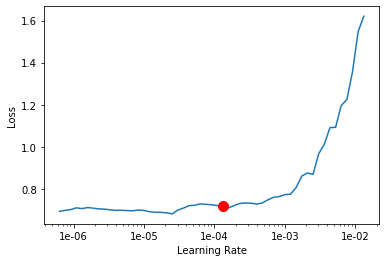

In [66]:
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.404633,0.334834,0.864560,0.135440,19:07
1,0.710428,0.696898,0.500000,0.500000,19:10
2,0.695162,0.696370,0.500000,0.500000,19:10
3,0.691192,0.695797,0.500000,0.500000,19:11
4,0.695383,0.693224,0.500000,0.500000,19:11


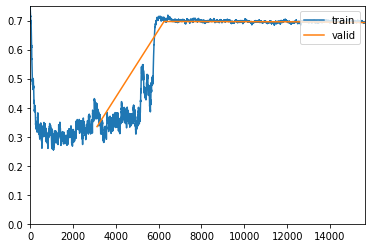

In [67]:
learner.fit_one_cycle(5, 1e-4, moms=(0.8,0.7))

In [51]:
learner.save('albert-no-pre-training-freezed')

In [40]:
# learner.load('no-pre-training-freezed');

## we only have 4 layer groups

In [52]:
len(learner.layer_groups)

4

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 2.29E-07


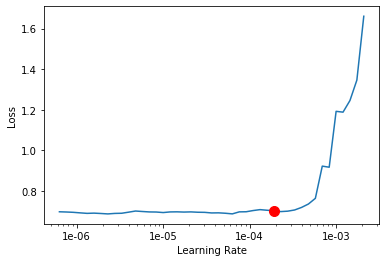

In [53]:
# since we have 14 layer_groups, we will unfreeze 2-3 layers to speed up the process
learner.freeze_to(-2)
torch.cuda.empty_cache()
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.188021,0.154190,0.942720,0.057280,11:49
1,0.149319,0.136903,0.949360,0.050640,11:14
2,0.119082,0.133555,0.951440,0.048560,11:13


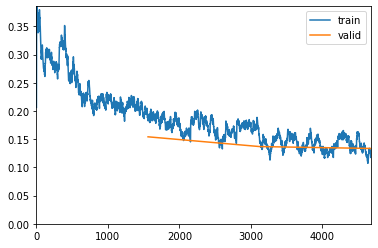

In [47]:
# ignore suggestion
learner.fit_one_cycle(3, 5e-5, moms=(0.8,0.7))

In [48]:
learner.save('no-pre-training-freez_to_-3')

In [ ]:
# learner.load('no-pre-training-freez_to_-3');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.31E-07


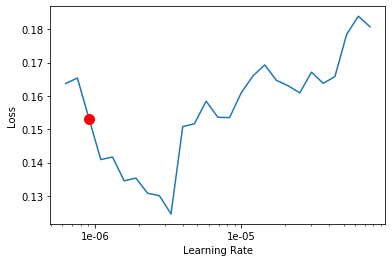

In [49]:
# since we have 14 layer_groups, we will unfreeze 2-3 layers to speed up the process
learner.freeze_to(-5)
torch.cuda.empty_cache()
learner.lr_find()
learner.recorder.plot(skip_end = 10, suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.127595,0.130388,0.952680,0.047320,11:48
1,0.127141,0.131005,0.953080,0.046920,12:39


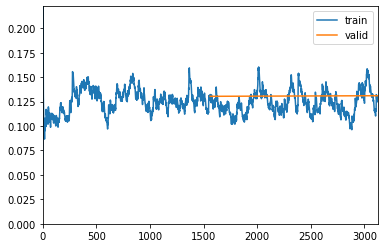

In [50]:
# ignore suggestion
learner.fit_one_cycle(2, 9.12E-07, moms=(0.8,0.7))

In [52]:
learner.save('no-pre-training-freez_to_-5')

In [38]:
learner.load('no-pre-training-freez_to_-5');

### We are able to get 95.3% accuracy without pre-finetuning

In the original guide of Jeremy Howard's ULMFiT for IMDB, he achieved **94.7%** accuracy. All the training strategies, like gradual unfreezing, learning rate annealing, batching are the same when constructing our `Learner`. Therefore, it's obvious that the `transformer` in stronger than `AWD_LSTM` for this task in terms of architecture.<br>

In the next notebook, we are going to push things further by incorporate the **ULMFiT** training procedure to the `transformer` training and see if we can get even better result.